In [121]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import statsmodels.api as sm
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [122]:
def encode_column(df, column_name):
    # Inicializamos el LabelEncoder
    le = LabelEncoder()
    
    # Aplicamos el encoding en la columna y almacenamos las clases para futuros usos
    df[column_name] = le.fit_transform(df[column_name])
    
    # Retornamos el dataframe y el LabelEncoder para transformaciones futuras
    return df, le

In [123]:
def encode_top_n(df, column_name, top_n=10):
    # Obtiene los top_n valores más frecuentes
    top_values = df[column_name].value_counts().nlargest(top_n).index
    
    # Reemplaza los valores menos frecuentes por 'otros'
    df[column_name] = df[column_name].apply(lambda x: x if x in top_values else "otros")
    df[column_name] = df[column_name].astype(str)
    # Aplica el LabelEncoder
    return df

In [124]:
df = pd.read_pickle("../output/base_etapa_2.pkl")

In [125]:
df_process = df.copy()

In [160]:
cluster_columns = [ 'irr_log',  'product_4', 'product_1', 'product_19', 'product_20']
cluster_columns = [ 'irr_log',  'product_4', 'segment_8', 'product_20', 'segment_1', 'product_16', 'product_7']
cluster_columns = [ 'product_4', 'segment_8', 'product_20', 'segment_1', 'product_16', 'product_7']

In [161]:
df_cluster = df_process[cluster_columns]

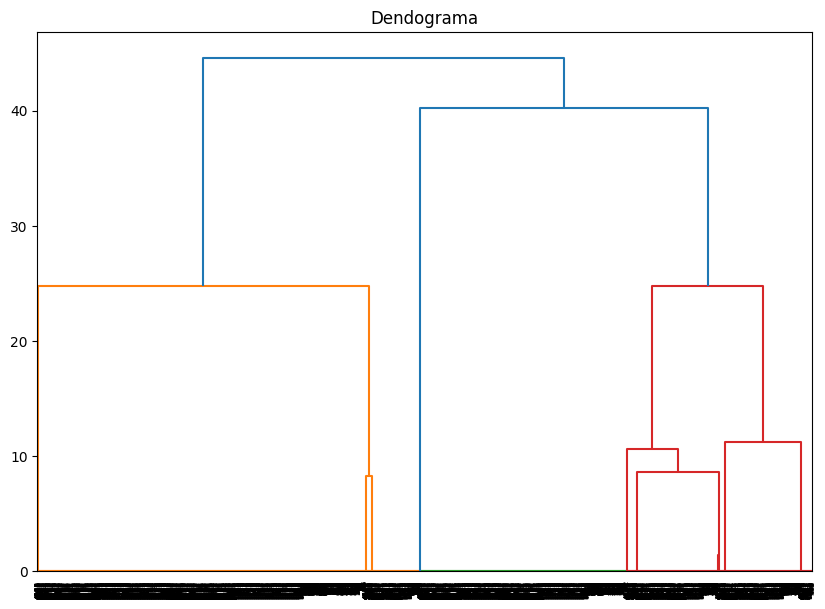

In [162]:
plt.figure(figsize=(10, 7))
plt.title("Dendograma")
dend = shc.dendrogram(shc.linkage(df_cluster.sample(5000), method='ward'))

In [185]:
cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
df_cluster['cluster'] = cluster.fit_predict(df_cluster)

In [186]:
df_dummies = pd.get_dummies(df_cluster['cluster'], prefix='segmento')
# Convertimos los valores booleanos a enteros si es necesario
df_dummies = df_dummies.astype(int)

In [187]:
df_segmento = pd.merge(df_process, df_cluster[["cluster"]], left_index=True, right_index=True)
df_segmento = df_segmento.groupby(by=["cluster"]).agg({"irr": "mean", "disbursed":"sum", "cluster":"count"}).reset_index(drop=True)
df_segmento["porcentaje"] = df_segmento["disbursed"] / df_segmento["cluster"]

In [188]:
df_analisis = pd.merge(df_process, df_dummies, left_index=True, right_index=True)

In [189]:
df_segmento

,irr,disbursed,cluster,porcentaje
0,19.892013,2648,5951,0.444967
1,19.947102,1120,2826,0.396320
2,19.664860,1644,3278,0.501525


In [190]:
df_analisis['ln_irr_seg_1'] = (df_analisis['irr_log']*df_analisis['segmento_1'])
df_analisis['ln_irr_seg_2'] = (df_analisis['irr_log']*df_analisis['segmento_2'])
#df_analisis['ln_irr_seg_3'] = (df_analisis['irr_log']*df_analisis['segmento_3'])
#df_analisis['ln_irr_seg_4'] = (df_analisis['irr_log']*df_analisis['segmento_4'])

In [191]:
df_analisis = df_analisis.reset_index(drop=True)

In [195]:
# Definimos los regresores y la variable dependiente
var_independiente = df_analisis[['irr_log', 
                                 'segmento_1', 'segmento_2', #'segmento_3', 'segmento_4', #'segmento_5',
                                 'ln_irr_seg_1', 'ln_irr_seg_2', #'ln_irr_seg_3', 'ln_irr_seg_4', #'ln_irr_seg_5'
                                 ]]
independiente = sm.add_constant(var_independiente, prepend=False)
dependiente = df_analisis['disbursed']

In [196]:
# Creamos el modelo de regresión lineal de mínimos cuadrados
modelo = sm.OLS(dependiente, independiente)

In [197]:
# Ajustamos el modelo para calcular los coeficientes de la función
resultado = modelo.fit()

# Se imprime los resultados del modelo
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:              disbursed   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     1637.
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        01:43:57   Log-Likelihood:                -5562.1
No. Observations:               12055   AIC:                         1.114e+04
Df Residuals:                   12049   BIC:                         1.118e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
irr_log         -2.1848      0.034    -63.413   

In [198]:
df_analisis["irr"].describe()

count    12055.000000
mean        19.843160
std          2.956696
min         16.500000
25%         17.400000
50%         18.600000
75%         22.200000
max         26.500000
Name: irr, dtype: float64

In [214]:
# Establecemos el rango de precios
rango_precios = np.linspace(16, 27, 20).round(2)

# Creamos el dataframe
df_elasticidad = pd.DataFrame(rango_precios)
df_elasticidad = df_elasticidad.rename({0: 'irr'}, axis=1)

In [215]:
# Preparamos los inputs para la predicción de demanda del segmento 0
X_data_seg0 = np.column_stack((np.log(df_elasticidad['irr']),
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 1  ## variable dummy
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 2
                          #np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 3
                          #np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 4
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 1  ##Interacción con el precio
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 2
                          #np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 3
                          #np.repeat(0, len(df_elasticidad['irr']))
                          )) # Interacción del precio y el segmento 4

In [216]:
# Preparamos los inputs para la predicción de demanda del segmento 1
X_data_seg1 = np.column_stack((np.log(df_elasticidad['irr']),
                          np.repeat(1, len(df_elasticidad['irr'])), # Coeficiente del segmento 1
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 2
                          #np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 3
                          #np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 4
                          np.log(df_elasticidad['irr']), # Interacción del precio y el segmento 1
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 2
                          #np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 3
                          #np.repeat(0, len(df_elasticidad['irr']))
                          )) # Interacción del precio y el segmento 4

In [217]:
# Preparamos los inputs para la predicción de demanda del segmento 2
X_data_seg2 = np.column_stack((np.log(df_elasticidad['irr']),
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 1
                          np.repeat(1, len(df_elasticidad['irr'])), # Coeficiente del segmento 2
                          #np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 3
                          #np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 4
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 1
                          np.log(df_elasticidad['irr']), # Interacción del precio y el segmento 2
                          #np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 3
                          #np.repeat(0, len(df_elasticidad['irr']))
                          )) # Interacción del precio y el segmento 4

In [213]:
# Preparamos los inputs para la predicción de demanda del segmento 3
X_data_seg3 = np.column_stack((np.log(df_elasticidad['irr']),
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 1
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 2
                          #np.repeat(1, len(df_elasticidad['irr'])), # Coeficiente del segmento 3
                          #np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 4
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 1
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 2
                          #np.log(df_elasticidad['irr']), # Interacción del precio y el segmento 3
                          #np.repeat(0, len(df_elasticidad['irr']))
                          )) # Interacción del precio y el segmento 4

In [204]:
# Preparamos los inputs para la predicción de demanda del segmento 4
X_data_seg4 = np.column_stack((np.log(df_elasticidad['irr']),
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 1
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 2
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 3
                          np.repeat(1, len(df_elasticidad['irr'])), # Coeficiente del segmento 4
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 1
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 2
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 3
                          np.log(df_elasticidad['irr']))) # Interacción del precio y el segmento 4

In [218]:
# Agregamos la constante del coeficiente de intercepción
X_data_seg0 = sm.add_constant(X_data_seg0, prepend=False, has_constant='add')
X_data_seg1 = sm.add_constant(X_data_seg1, prepend=False, has_constant='add')
X_data_seg2 = sm.add_constant(X_data_seg2, prepend=False, has_constant='add')
# X_data_seg3 = sm.add_constant(X_data_seg3, prepend=False, has_constant='add')
# X_data_seg4 = sm.add_constant(X_data_seg4, prepend=False, has_constant='add')

In [220]:
# Predecimos las nuevas cantidades demandadas (previa conversión de logaritmo natural)
df_elasticidad['cantidad_seg0'] = np.exp(resultado.predict(X_data_seg0))
df_elasticidad['cantidad_seg1'] = np.exp(resultado.predict(X_data_seg1))
df_elasticidad['cantidad_seg2'] = np.exp(resultado.predict(X_data_seg2))
# df_elasticidad['cantidad_seg3'] = np.exp(resultado.predict(X_data_seg3))
# df_elasticidad['cantidad_seg4'] = np.exp(resultado.predict(X_data_seg4))
df_elasticidad.head()

,irr,cantidad_seg0,cantidad_seg1,cantidad_seg2
0,16.00,2.452854,2.287199,2.630060
1,16.58,2.269261,2.125851,2.417276
2,17.16,2.105034,1.980862,2.228161
3,17.74,1.957575,1.850101,2.059412
4,18.32,1.824704,1.731772,1.908272


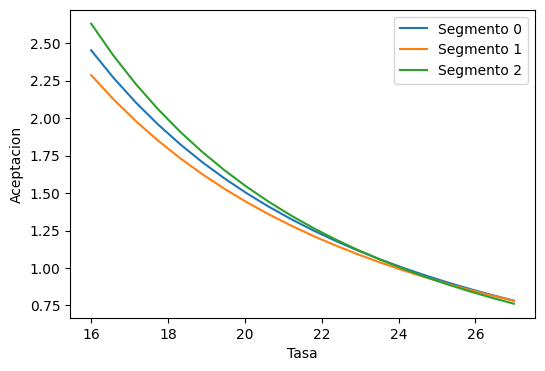

In [221]:
# Crear la figura
plt.figure(figsize=(6, 4))

# Graficar cada línea con `plot`
plt.plot(df_elasticidad["irr"], df_elasticidad["cantidad_seg0"], label='Segmento 0')
plt.plot(df_elasticidad["irr"], df_elasticidad["cantidad_seg1"], label='Segmento 1')
plt.plot(df_elasticidad["irr"], df_elasticidad["cantidad_seg2"], label='Segmento 2')
# plt.plot(df_elasticidad["irr"], df_elasticidad["cantidad_seg3"], label='Segmento 3')
# plt.plot(df_elasticidad["irr"], df_elasticidad["cantidad_seg4"], label='Segmento 4')

# Añadir etiquetas y leyenda
plt.xlabel('Tasa')
plt.ylabel('Aceptacion')
plt.legend()

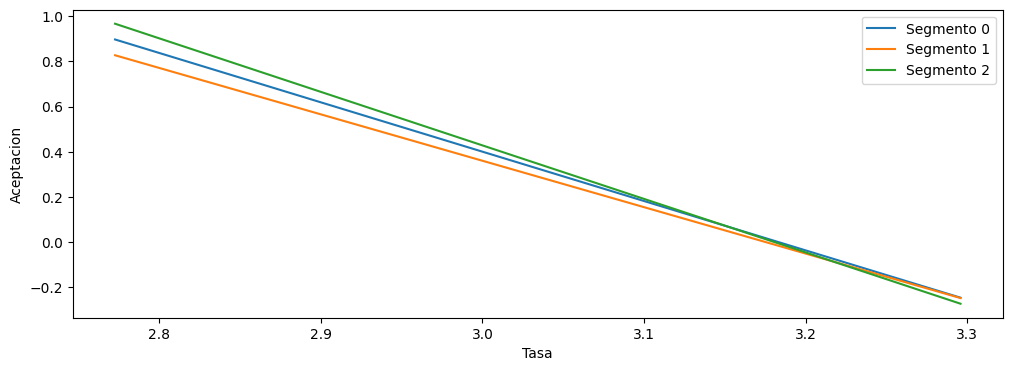

In [222]:
# Crear la figura
plt.figure(figsize=(12, 4))

# Graficar cada línea con `plot`
plt.plot(np.log(df_elasticidad["irr"]), np.log(df_elasticidad["cantidad_seg0"]), label='Segmento 0')
plt.plot(np.log(df_elasticidad["irr"]), np.log(df_elasticidad["cantidad_seg1"]), label='Segmento 1')
plt.plot(np.log(df_elasticidad["irr"]), np.log(df_elasticidad["cantidad_seg2"]), label='Segmento 2')
# plt.plot(np.log(df_elasticidad["irr"]), np.log(df_elasticidad["cantidad_seg3"]), label='Segmento 3')
# plt.plot(np.log(df_elasticidad["irr"]), np.log(df_elasticidad["cantidad_seg4"]), label='Segmento 4')

# Añadir etiquetas y leyenda
plt.xlabel('Tasa')
plt.ylabel('Aceptacion')
plt.legend()

In [223]:
df_elasticidad.to_pickle("../output/base_etapa_3.pkl")